# Discriminator Tutorial

In [6]:
%load_ext autoreload
%autoreload 2
import numpy as np
from qiskit.providers import BaseBackend
from qiskit.providers.models import QasmBackendConfiguration
from qiskit.result import Result
from qiskit.test import QiskitTestCase
from qiskit_experiments.measurement.discriminator import Discriminator
from qiskit_experiments.measurement.discriminator import DiscriminatorAnalysis
from qiskit_experiments.composite import ParallelExperiment


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
class DiscriminatorBackend(BaseBackend):
    """
    A simple backend that generates gaussian data for discriminator tests
    """

    def __init__(self, seed=None):
        """
        Initialize the discriminator backend
        """
        configuration = QasmBackendConfiguration(
            backend_name="discriminator_simulator",
            backend_version="0",
            n_qubits=int(1e6),
            basis_gates=["x", "measure"],
            gates=[],
            local=True,
            simulator=True,
            conditional=False,
            open_pulse=False,
            memory=False,
            max_shots=int(1e6),
            coupling_map=None,
        )

        super().__init__(configuration)
        self.rng = np.random.default_rng(seed)

    def sample_gaussian(self, centroid=np.array([0,0]), cov=np.array([[0.1,0],[0,0.1]]), size=1):
        """
        Draws random samples from a gaussian distribution.
        """
        return self.rng.multivariate_normal(centroid, cov, size)

    # pylint: disable = arguments-differ
    def run(self, qobj):
        """
        Run the discriminator backend
        """

        shots = qobj.config.shots

        result = {
            "backend_name": "Discriminator backend",
            "backend_version": "0",
            "qobj_id": 0,
            "job_id": 0,
            "success": True,
            "results": [],
        }

        for circ in qobj.experiments:
            nqubits = circ.config.n_qubits
            centroids = np.zeros([nqubits, 2])
            counts = dict()
            memory = np.zeros([shots, circ.config.memory_slots, 2])

            for i in range(shots):
                clbits = np.zeros(circ.config.memory_slots, dtype=int)
                meas_res = 0
                for op in circ.instructions:
                    qubit = op.qubits[0]
                    if op.name == "x":
                        meas_res=1
                    elif op.name == "measure":
                        # centroid is either (0,0) for |0> or (1,1) for |1>
                        memory[i, op.memory[0]] = self.sample_gaussian(centroid=np.array([meas_res, meas_res]))
                        clbits[op.memory[0]] = meas_res

                clstr = ""
                for clbit in clbits[::-1]:
                    clstr = clstr + str(clbit)

                if clstr in counts:
                    counts[clstr] += 1
                else:
                    counts[clstr] = 1

            result["results"].append(
                {
                    "shots": shots,
                    "success": True,
                    "header": {"metadata": circ.header.metadata},
                    "data": {"counts": counts, "memory": memory},
                }
            )

        return Result.from_dict(result)

## Run Example Discriminator Experiment on One Qubit

---------------------------------------------------
Experiment: Discriminator
Experiment ID: 47607ad0-0b4f-4978-b955-0c2276c35d8e
Status: DONE
Circuits: 2
Analysis Results: 1
---------------------------------------------------
Last Analysis Result
- discriminator: LinearDiscriminantAnalysis()
- coef: [[10.35183263 10.60051012]]
- intercept: [-10.37682244]
- score: 0.9905
- plt: AxesSubplot(0.125,0.125;0.775x0.755)
- success: True


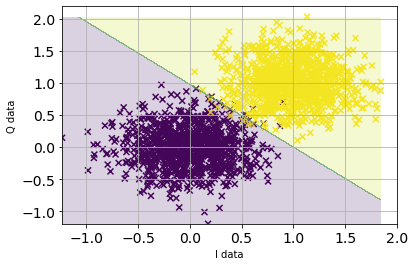

In [8]:
backend = DiscriminatorBackend(0)
exp = Discriminator(1)
lda_res = exp.run(
    backend,
    shots=1000,
    discriminator_type="LDA"
)
print(lda_res)

---------------------------------------------------
Experiment: Discriminator
Experiment ID: d16a4469-9328-4973-91cd-7a8b3a4f296a
Status: DONE
Circuits: 2
Analysis Results: 1
---------------------------------------------------
Last Analysis Result
- discriminator: QuadraticDiscriminantAnalysis()
- rotations: [array([[-0.99992655, -0.0121197 ],
       [-0.0121197 ,  0.99992655]]), array([[-0.99991046, -0.01338155],
       [ 0.01338155, -0.99991046]])]
- score: 0.988
- plt: AxesSubplot(0.125,0.125;0.775x0.755)
- success: True


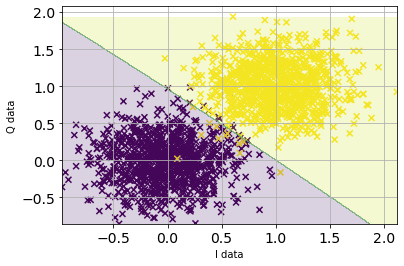

In [9]:
from qiskit_experiments.measurement.discriminator import Discriminator, DiscriminatorAnalysis

backend = DiscriminatorBackend(2)
exp = Discriminator(1)
exp.set_analysis_options(discriminator_type="QDA")

qda_res = exp.run(
    backend,
    shots=1000
)
print(qda_res)

## Run Discriminator Experiments in Parallel 

---------------------------------------------------
Experiment: ParallelExperiment
Experiment ID: df51a01c-6af9-4fa7-969d-b27af682db2e
Status: DONE
Component Experiments: 3
Circuits: 2
Analysis Results: 1
---------------------------------------------------
Last Analysis Result
- experiment_types: ['Discriminator', 'Discriminator', 'Discriminator']
- experiment_ids: ['037e196e-a7ce-4333-85d8-303cca0323b8', '2fa8a668-9243-4126-8c15-ecbc048132ce', '7bcc45d6-8dde-469e-937a-7c46390f7d4b']
- experiment_qubits: [(0,), (1,), (2,)]
- success: True


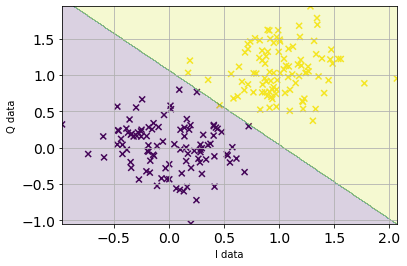

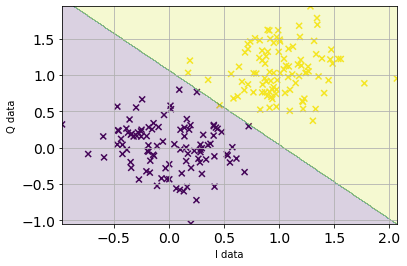

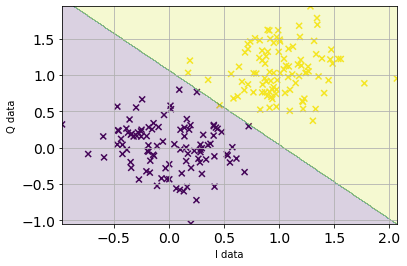

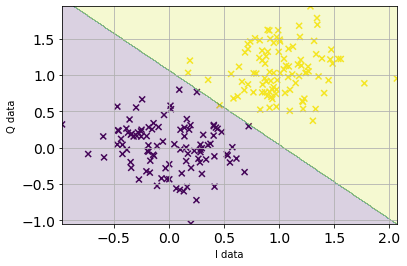

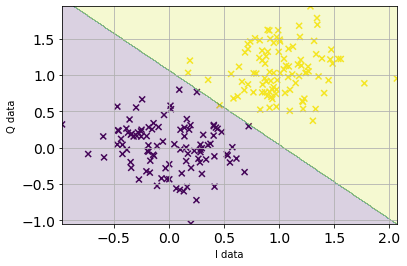

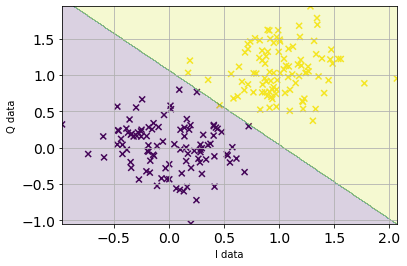

In [10]:
from qiskit_experiments.measurement.discriminator import Discriminator, DiscriminatorAnalysis
from qiskit_experiments.composite import ParallelExperiment

exps = [Discriminator(i) for i in range(3)]

par_exp = ParallelExperiment(exps)
par_expdata = par_exp.run(backend, shots=100)
print(par_expdata)

## Use Data Processor Discriminator Node

In [12]:
lda_res.data(0)

{'counts': {'0': 1000},
 'memory': array([[[ 0.03975939, -0.04177523]],
 
        [[ 0.20251942,  0.03317233]],
 
        [[-0.16939353,  0.1143464 ]],
 
        ...,
 
        [[ 0.39519783,  0.2373713 ]],
 
        [[-0.17576437, -0.63840429]],
 
        [[-0.28758625,  0.11676057]]]),
 'metadata': {'experiment_type': 'Discriminator',
  'ylabel': '0',
  'qubit': 1,
  'meas_level': <MeasLevel.KERNELED: 1>,
  'meas_return': 'single'}}

In [11]:
from qiskit_experiments.data_processing.data_processor import DataProcessor
from qiskit_experiments.data_processing.exceptions import DataProcessorError
from qiskit_experiments.data_processing.nodes import (
    ToReal,
    ToImag,
    Probability,
    Discriminator
)

# LDA node
processor = DataProcessor("memory", [Discriminator(lda_res)])
processor.append(Probability("0"))
datum = processor(lda_res.data(0))

print(datum)

# QDA node
processor = DataProcessor("memory", [Discriminator(qda_res)])
processor.append(Probability("0"))
datum = processor(qda_res.data(0))

print(datum)

TypeError: _process() takes from 2 to 3 positional arguments but 1001 were given

Using a parallel experiment to discriminate over multiple qubits:

In [95]:
processor = DataProcessor("memory", [Discriminator(par_expdata)])
processor.append(Probability("000"))
datum = processor(par_expdata.data(0))

print(datum)

(0.95, 0.021794494717703377)


In [36]:
from qiskit_experiments.data_processing.data_processor import DataProcessor
from qiskit_experiments.data_processing.exceptions import DataProcessorError
from qiskit_experiments.data_processing.nodes import (
    ToReal,
    ToImag,
    Probability,
    Discriminator
)
processor = DataProcessor("memory", [Discriminator(par_expdata)])
processor.append(Probability("000"))
datum = processor(par_expdata.data(0))

print(datum)

[autoreload of qiskit_experiments.data_processing.nodes failed: Traceback (most recent call last):
  File "/Users/Helena.Zhang@ibm.com/Documents/GitHub/playground/pydantic-workshop/lib/python3.8/site-packages/IPython/extensions/autoreload.py", line 245, in check
    superreload(m, reload, self.old_objects)
  File "/Users/Helena.Zhang@ibm.com/Documents/GitHub/playground/pydantic-workshop/lib/python3.8/site-packages/IPython/extensions/autoreload.py", line 410, in superreload
    update_generic(old_obj, new_obj)
  File "/Users/Helena.Zhang@ibm.com/Documents/GitHub/playground/pydantic-workshop/lib/python3.8/site-packages/IPython/extensions/autoreload.py", line 347, in update_generic
    update(a, b)
  File "/Users/Helena.Zhang@ibm.com/Documents/GitHub/playground/pydantic-workshop/lib/python3.8/site-packages/IPython/extensions/autoreload.py", line 302, in update_class
    if update_generic(old_obj, new_obj): continue
  File "/Users/Helena.Zhang@ibm.com/Documents/GitHub/playground/pydantic-w

TypeError: _process() takes from 2 to 3 positional arguments but 101 were given